In [18]:
import cPickle as pickle
import pandas as pd
import numpy as np
import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# local code
import sys
sys.path.insert(0, '/Users/zgreyn/Documents/galvanize/projects/nfl/src')
import combine
import clean
import scrape
import modeling

import matplotlib
import seaborn
%matplotlib inline

In [19]:
def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Split off a validation set for the users and models to compete over; work with just the training set

In [20]:
# read in the cleaned training data
pbp = pd.read_csv('../data/pbp-training.csv')

In [4]:
print 'training set:  ', pbp.shape

training set:   (109372, 33)


In [5]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109372 entries, 0 to 109371
Data columns (total 33 columns):
index                109372 non-null int64
GAMEID               109372 non-null int64
GAMEDATE             109372 non-null object
QUARTER              109372 non-null int64
MINUTE               109372 non-null int64
SECOND               109372 non-null int64
OFFENSETEAM          109372 non-null object
DEFENSETEAM          109372 non-null object
DOWN                 109372 non-null int64
TOGO                 109372 non-null int64
YARDLINE             109372 non-null int64
DESCRIPTION          109372 non-null object
SEASONYEAR           109372 non-null int64
YARDS                109372 non-null int64
FORMATION            109371 non-null object
PLAYTYPE             109372 non-null object
PASSTYPE             55084 non-null object
RUSHDIRECTION        36707 non-null object
YARDLINEFIXED        109372 non-null int64
YARDLINEDIRECTION    109372 non-null object
PLAY                 1

In [21]:
# run the prep (dummy out TEAM and FORMATION, keep only some of the columns, replace UNKNOWN values with 'indoor' defaults)
pbp_prep = modeling.prep_records(pbp)

In [7]:
pbp_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109372 entries, 0 to 109371
Data columns (total 54 columns):
QUARTER                        109372 non-null int64
MINUTE                         109372 non-null int64
SECOND                         109372 non-null int64
DOWN                           109372 non-null int64
TOGO                           109372 non-null int64
YARDLINE                       109372 non-null int64
SCORINGMARGIN                  109372 non-null float64
ISTURF                         109372 non-null float64
UNDERROOF                      109372 non-null float64
ISATHOME                       109372 non-null int64
TEMPERATURE                    109372 non-null int64
HUMIDITY                       109372 non-null int64
WINDSPEED                      109372 non-null int64
SEASONYEAR                     109372 non-null int64
PLAY                           109372 non-null int64
TEAM_ARI                       109372 non-null uint8
TEAM_ATL                       1093

In [8]:
# split the class from the values
y = pbp_prep['PLAY']
X = pbp_prep.drop(['PLAY'], axis=1).values
col_names = pbp_prep.drop(['PLAY'], axis=1).columns

In [9]:
# read in the cleaned training data
pbp_v = pd.read_csv('../data/pbp-validation.csv')
pbp_v_prep = modeling.prep_records(pbp_v)

In [10]:
pbp_v.shape

(12153, 33)

In [11]:
# split the class from the values
y_test = pbp_v_prep['PLAY']
X_test = pbp_v_prep.drop(['PLAY'], axis=1).values

### Basic Model Using All Seasons and All Teams

In [12]:
# gradient boosting classifier
gbc = GradientBoostingClassifier(subsample=0.5)
gbc.fit(X, y)
print(cross_val_score(gbc, X, y)) 

[ 0.75736464  0.75149487  0.75249616]


0.761128939357
[[1143    8   10]
 [  20 5465 1322]
 [  10 1533 2642]]


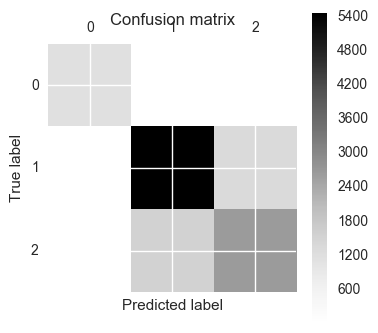

In [13]:
y_pred = gbc.predict(X_test)
print gbc.score(X_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [148]:
# save the model
with open('../data/gbc-v4.pkl', 'w') as f:
    pickle.dump(gbc, f)

### Try putting in the season

In [34]:
df16 = pd.read_csv('../data/pbp2016-clean.csv')
df15 = pd.read_csv('../data/pbp2015-clean.csv')
df14 = pd.read_csv('../data/pbp2014-clean.csv')
df13 = pd.read_csv('../data/pbp2013-clean.csv')

In [35]:
df16['Season'] = 2016
df15['Season'] = 2015
df14['Season'] = 2014
df13['Season'] = 2013

In [36]:
df = pd.concat([df16, df15, df14, df13])

In [37]:
df_prepped = prep(df)

In [38]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [39]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [40]:
gbc.score(X_test, y_test)

0.76352592592592594

[[ 3150     3    12]
 [    6 14807  3999]
 [    7  3954  7812]]


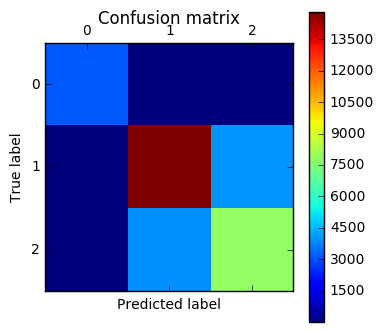

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Tried this experiment without the 2016 data and it seems to make things worse

### Try losing the offense

In [42]:
df = pbp_train_raw.copy()

In [43]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [44]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,1,7,30,1,10,31,PASS,0,0,0,0,0,1,0
1,3,7,10,2,7,90,PASS,0,0,0,0,1,0,0
2,4,4,53,4,21,59,KICK,0,0,0,1,0,0,0
3,4,5,30,1,1,99,RUSH,0,0,0,0,0,1,0
4,3,7,20,3,5,75,PASS,0,0,1,0,0,0,0


In [45]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [46]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [47]:
gbc.score(X_test, y_test)

0.76651851851851849

[[ 2866     1     5]
 [   15 13367  3489]
 [    6  3576  7050]]


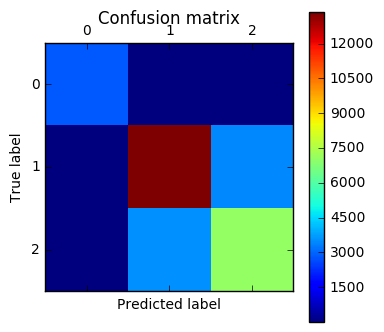

In [48]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight decline here; this should still be suitable for a prior "conventional wisdom" model

### Try keeping the defense in

In [149]:
df = pbp_train_raw.copy()

In [150]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for offensive teams
off_team_dummies = pd.get_dummies(df.OffenseTeam)
off_team_dummies.columns = map(lambda x: 'OFF_' + str(x), off_team_dummies.columns)

# create dummy variables for offensive teams
def_team_dummies = pd.get_dummies(df.DefenseTeam)
def_team_dummies.columns = map(lambda x: 'DEF_' + str(x), def_team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    off_team_dummies,
    def_team_dummies,
    form_dummies], axis=1)

In [151]:
df_prepped.columns

Index([u'Quarter', u'Minute', u'Second', u'Down', u'ToGo', u'YardLine',
       u'Play', u'OFF_ARI', u'OFF_ATL', u'OFF_BAL', u'OFF_BUF', u'OFF_CAR',
       u'OFF_CHI', u'OFF_CIN', u'OFF_CLE', u'OFF_DAL', u'OFF_DEN', u'OFF_DET',
       u'OFF_GB', u'OFF_HOU', u'OFF_IND', u'OFF_JAX', u'OFF_KC', u'OFF_LA',
       u'OFF_MIA', u'OFF_MIN', u'OFF_NE', u'OFF_NO', u'OFF_NYG', u'OFF_NYJ',
       u'OFF_OAK', u'OFF_PHI', u'OFF_PIT', u'OFF_SD', u'OFF_SEA', u'OFF_SF',
       u'OFF_TB', u'OFF_TEN', u'OFF_WAS', u'DEF_ARI', u'DEF_ATL', u'DEF_BAL',
       u'DEF_BUF', u'DEF_CAR', u'DEF_CHI', u'DEF_CIN', u'DEF_CLE', u'DEF_DAL',
       u'DEF_DEN', u'DEF_DET', u'DEF_GB', u'DEF_HOU', u'DEF_IND', u'DEF_JAX',
       u'DEF_KC', u'DEF_LA', u'DEF_MIA', u'DEF_MIN', u'DEF_NE', u'DEF_NO',
       u'DEF_NYG', u'DEF_NYJ', u'DEF_OAK', u'DEF_PHI', u'DEF_PIT', u'DEF_SD',
       u'DEF_SEA', u'DEF_SF', u'DEF_TB', u'DEF_TEN', u'DEF_WAS',
       u'FORMATION_FIELD_GOAL', u'FORMATION_NO_HUDDLE',
       u'FORMATION_NO_HUDDLE_SHOTG

In [152]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [153]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [154]:
gbc.score(X_test, y_test)

0.76678189300411526

[[ 2835     4     9]
 [   17 13417  3505]
 [    2  3547  7039]]


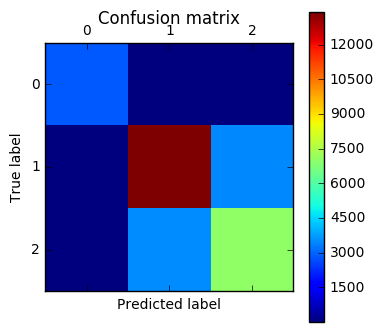

In [155]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight lift from using the defense; not enough to worry about

### Try using the no-offense model as a prior for another team-based model

* After discussing this, it won't help to stack the same model on itself.  If we're going to stack, vary the model types.  Also, don't use the probabilities as features, use the log-odds.

#### Train a no-offense model

In [156]:
df = pbp_train_raw.copy()

In [157]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [158]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,3,4,8,1,10,46,PASS,0,0,0,0,0,1,0
1,3,6,3,1,10,31,PASS,0,0,0,0,0,1,0
2,2,11,40,1,10,20,PASS,0,0,0,0,0,1,0
3,3,8,8,1,10,17,RUSH,0,0,0,0,1,0,0
4,1,7,3,4,4,24,KICK,0,0,0,1,0,0,0


In [159]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

In [160]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [161]:
def get_probas(record):
    
    '''
    This takes a dataframe and puts it in the format the conventional wisdom model expects.
    '''

    formations = [
    'FIELD_GOAL',
    'NO_HUDDLE',
    'NO_HUDDLE_SHOTGUN',
    'PUNT',
    'SHOTGUN',
    'UNDER_CENTER',
    'WILDCAT']


    # Dummy the formation
    df1 = pd.get_dummies(record.Formation)
    dummies_frame = pd.get_dummies(formations)
    df1 = df1.reindex(columns=dummies_frame.columns, fill_value=0)
    df1.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), df1.columns)

    # Combine the dummy variables and drop the categorical versions
    record = pd.concat(
        [record.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        df1], axis=1)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [162]:
df_new = pbp_train_raw.copy()

In [163]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [164]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([  3.35305816e-04,   8.05174560e-01,   1.94490134e-01])

#### apply it to the whole dataframe

In [165]:
probas = get_probas(df_new)

In [166]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [167]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Quarter                                                              1
Minute                                                              11
Second                                                              29
OffenseTeam                                                        IND
DefenseTeam                                                        ATL
Down                                                                 2
ToGo                                                                 6
YardLine                                                            54
Description          (11:29) (SHOTGUN) 23-F.GORE RIGHT GUARD TO ATL...
Yards                                                                0
Formation                                                      SHOTGUN
PlayType                                                          RUSH
PassType                                                           NaN
RushDirection                                              RIGHT GUARD
YardLi

#### now, dummy out the teams and formations and train a new model

In [168]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [169]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [170]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [171]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [172]:
gbc.score(X_test, y_test)

0.76839506172839511

[[ 2836     4     8]
 [   17 13458  3464]
 [    2  3540  7046]]


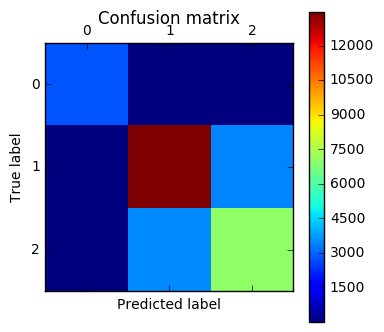

In [173]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### This shows a .15% improvement, which is nominal.  Formation went into the prior model... it probably shouldn't have, since that decision is offense-specific.

### Try again, but leave formation out of the prior model.

In [174]:
df = pbp_train_raw.copy()

In [175]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation'], axis=1, inplace=True)

In [176]:
df.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play
0,3,4,8,1,10,46,PASS
1,3,6,3,1,10,31,PASS
2,2,11,40,1,10,20,PASS
3,3,8,8,1,10,17,RUSH
4,1,7,3,4,4,24,KICK


In [177]:
# split the class from the values
y = df['Play']
X = df.drop(['Play'], axis=1).values

In [178]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [179]:
def get_probas(record):
    
    # A few columns have to go for us to build a model (though we use them for user presentation)
    record.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation'], axis=1, inplace=True)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [180]:
df_new = pbp_train_raw.copy()

In [181]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [182]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([ 0.00119482,  0.50972893,  0.48907625])

#### apply it to the whole dataframe

In [183]:
probas = get_probas(df_new.copy())

In [184]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [185]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Quarter                                                              2
Minute                                                               5
Second                                                              55
OffenseTeam                                                        ARI
DefenseTeam                                                        DET
Down                                                                 1
ToGo                                                                10
YardLine                                                            30
Description          (5:55) (SHOTGUN) 5-D.STANTON PASS INCOMPLETE D...
Yards                                                                0
Formation                                                      SHOTGUN
PlayType                                                          PASS
PassType                                                     DEEP LEFT
RushDirection                                                      NaN
YardLi

#### now, dummy out the teams and formations and train a new model

In [186]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [187]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [188]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [189]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [190]:
gbc.score(X_test, y_test)

0.76882304526748968

[[ 2829    13     6]
 [   15 13521  3403]
 [    2  3583  7003]]


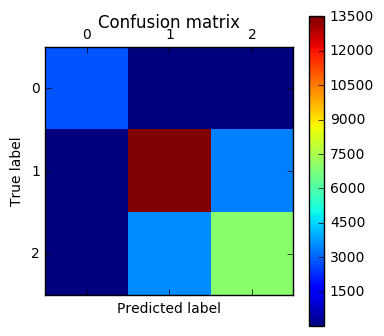

In [191]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Less improvement than leaving formation in, but a fraction of a percent (0.08%) better than the basic model

### Throw the kitchen sink at the data and see if any other models show promise

In [18]:
names = [
    "Nearest Neighbors", 
    "Linear SVM", 
    #"RBF SVM", 
    #"Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net", 
    "AdaBoost",
    "Naive Bayes", 
    "QDA", 
    "Gradient Boosting", 
    "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier(),
    LogisticRegression()]


In [19]:
def get_scores(model, X_train, X_test, y_train, y_test, labels):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict, average='weighted', labels=labels), \
           recall_score(y_test, y_predict, average='weighted', labels=labels)

In [20]:
#print gbc.classes_
labels = ['KICK', 'PASS', 'RUSH']

In [ ]:
# try out each of the classifiers
for name, clf in zip(names, classifiers):
    print name, ":", get_scores(clf, X, X_test, y, y_test, labels)

Nearest Neighbors :

/Users/zgreyn/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:375: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 (0.50703529992594421, 0, 0)
Linear SVM :

## Try out some of the new features

In [62]:
def train_and_evaluate(columns_to_keep):
    # run the prep (dummy out TEAM and FORMATION, keep only some of the columns, replace UNKNOWN values with 'indoor' defaults)
    pbp_prep = modeling.prep_records(pbp, columns_to_keep)

    # save a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

    # gradient boosting classifier
    gbc = GradientBoostingClassifier(subsample=0.5)
    gbc.fit(X_train, y_train)
    print(cross_val_score(gbc, X, y)) 

    y_pred = gbc.predict(X_test)

    print gbc.score(X_test, y_test)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [72]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    #'ISTURF',
    #'UNDERROOF',
    #'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75695321  0.74943771  0.75241387]
0.759024247522
[[ 2523    15    25]
 [   38 12202  2949]
 [   38  3524  6029]]


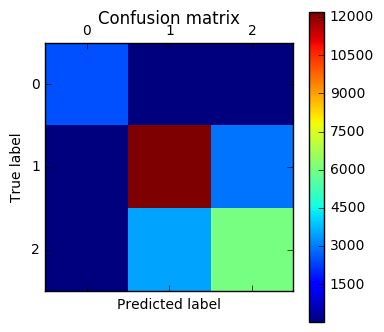

In [73]:
train_and_evaluate(columns_to_keep)

In [74]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    #'UNDERROOF',
    #'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75643206  0.75144001  0.75282532]
0.757524777822
[[ 2521    15    27]
 [   37 12170  2982]
 [   37  3532  6022]]


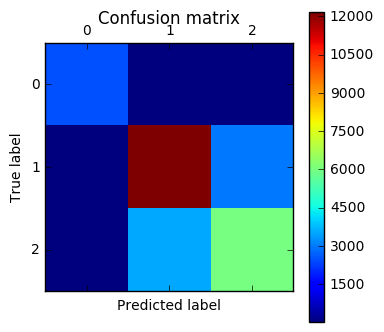

In [75]:
train_and_evaluate(columns_to_keep)

In [76]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    'UNDERROOF',
    #'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75648692  0.75080915  0.75255102]
0.760816296676
[[ 2524    14    25]
 [   38 12214  2937]
 [   37  3489  6065]]


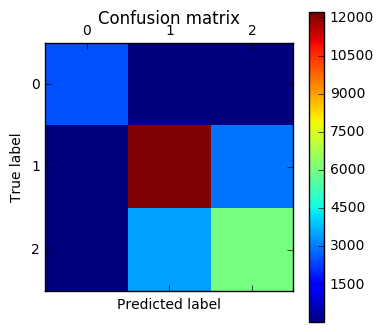

In [77]:
train_and_evaluate(columns_to_keep)

In [78]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    'UNDERROOF',
    'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75571891  0.7515223   0.75315449]
0.757817357276
[[ 2519    14    30]
 [   36 12212  2941]
 [   37  3564  5990]]


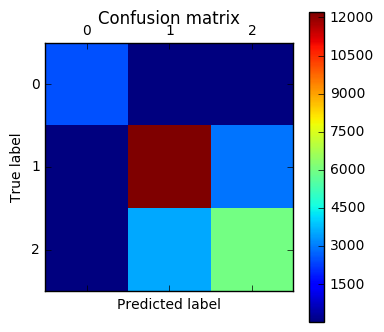

In [79]:
train_and_evaluate(columns_to_keep)

In [86]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    'UNDERROOF',
    'ISATHOME',
    'TEMPERATURE',
    'HUMIDITY',
    'WINDSPEED',
    'PLAY']

[ 0.75547205  0.75108344  0.75301734]
0.758365943752
[[ 2523    14    26]
 [   39 12153  2997]
 [   40  3491  6060]]


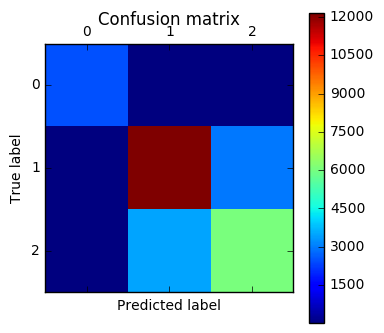

In [87]:
train_and_evaluate(columns_to_keep)

In [82]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    #'SCORINGMARGIN',
    #'ISTURF',
    #'UNDERROOF',
    #'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75629491  0.75058972  0.7533465 ]
0.760194565337
[[ 2520    15    28]
 [   38 12202  2949]
 [   39  3488  6064]]


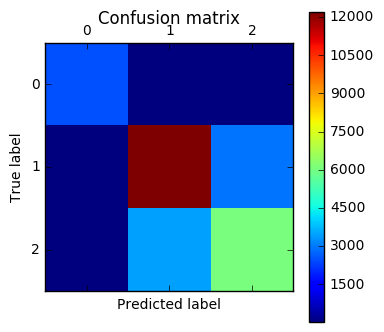

In [83]:
train_and_evaluate(columns_to_keep)

In [84]:
columns_to_keep = [
    #'QUARTER',
    #'MINUTE',
    #'SECOND',
    'DOWN',
    'TOGO',
    #'YARDLINE',
    #'SCORINGMARGIN',
    #'ISTURF',
    #'UNDERROOF',
    #'ISATHOME',
    #'TEMPERATURE',
    #'HUMIDITY',
    #'WINDSPEED',
    'PLAY']

[ 0.75602063  0.75031543  0.75364823]
0.759426544271
[[ 2522    15    26]
 [   38 12210  2941]
 [   42  3516  6033]]


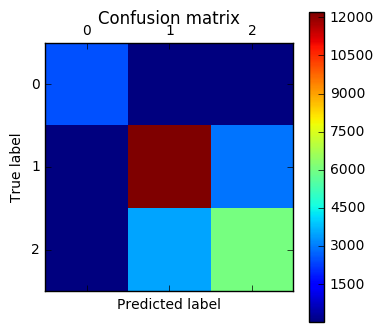

In [85]:
train_and_evaluate(columns_to_keep)

## Check feature importances

In [3]:
columns_to_keep = [
    'QUARTER',
    'MINUTE',
    'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    'UNDERROOF',
    'ISATHOME',
    'TEMPERATURE',
    'HUMIDITY',
    'WINDSPEED',
    'SEASONYEAR',
    'PLAY']

In [4]:
# run the prep (dummy out TEAM and FORMATION, keep only some of the columns, replace UNKNOWN values with 'indoor' defaults)
pbp_prep = modeling.prep_records(pbp, columns_to_keep, offense=True, formation=True)

In [22]:
# split the class from the values
y = pbp_prep['PLAY']
X = pbp_prep.drop(['PLAY'], axis=1).values
col_names = pbp_prep.drop(['PLAY'], axis=1).columns

In [23]:
from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

Feature ranking:
1. feature DOWN (0.139212)
2. feature FORMATION_SHOTGUN (0.108295)
3. feature FORMATION_PUNT (0.092161)
4. feature YARDLINE (0.081118)
5. feature SECOND (0.078662)
6. feature SCORINGMARGIN (0.071852)
7. feature MINUTE (0.071680)
8. feature TOGO (0.053518)
9. feature QUARTER (0.042766)
10. feature TEMPERATURE (0.034957)
11. feature SEASONYEAR (0.034773)
12. feature HUMIDITY (0.034611)
13. feature WINDSPEED (0.033027)
14. feature ISATHOME (0.011134)
15. feature ISTURF (0.010825)
16. feature UNDERROOF (0.005875)
17. feature TEAM_PHI (0.003667)
18. feature TEAM_SF (0.003499)
19. feature TEAM_WAS (0.003450)
20. feature TEAM_SD (0.003398)
21. feature TEAM_CHI (0.003385)
22. feature TEAM_KC (0.003247)
23. feature TEAM_PIT (0.003205)
24. feature TEAM_NE (0.003203)
25. feature TEAM_GB (0.003200)
26. feature TEAM_OAK (0.003182)
27. feature TEAM_DEN (0.003152)
28. feature TEAM_HOU (0.003125)
29. feature TEAM_NYG (0.003040)
30. feature TEAM_CLE (0.003030)
31. feature TEAM_TEN (0.0

(-1, 53)

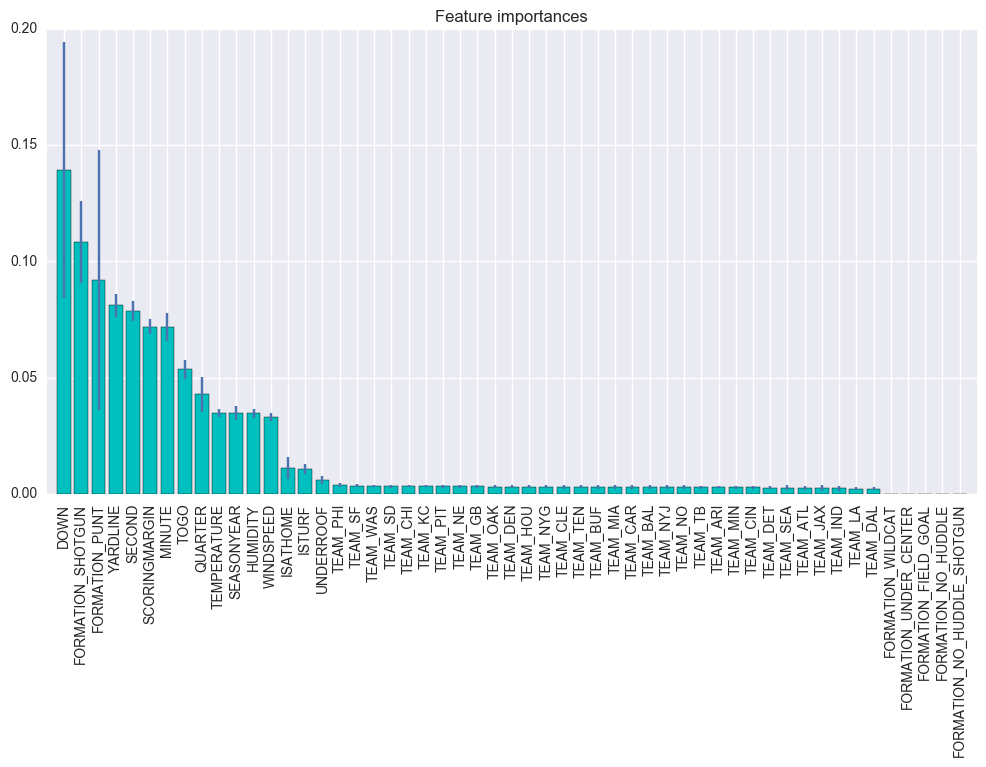

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feature_names = []
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col_names[indices[f]], importances[indices[f]]))
    feature_names.append(col_names[indices[f]])
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="c", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])

## Train one with everything and use GridSearch to narrow

In [43]:
# read in the cleaned training data
pbp = pd.read_csv('../data/pbp-training.csv')

In [63]:
# run the prep (dummy out TEAM and FORMATION, keep only some of the columns, replace UNKNOWN values with 'indoor' defaults)
pbp_prep = modeling.prep_records(pbp)

In [65]:
# split the class from the values
y = pbp_prep['PLAY']
X = pbp_prep.drop(['PLAY'], axis=1).values
col_names = pbp_prep.drop(['PLAY'], axis=1).columns

In [66]:
gd_grid = {'learning_rate': [0.1, 0.01],
               'max_depth': [4, 8, 14],
               'min_samples_leaf': [5, 10, 20, 100],
               'max_features': [1.0, 0.5, 0.1],
               'n_estimators': [500, 100],
               'random_state': [22]}

In [67]:
def grid_search(est, grid):
    grid_cv = GridSearchCV(est, grid, n_jobs=-1, verbose=1).fit(X, y)
    return grid_cv

In [ ]:
# gradient boosting classifier
gd_grid_search = grid_search(GradientBoostingClassifier(), gd_grid)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 117.4min


In [15]:
#gd_best = gd_grid_search.best_estimator_
with open('../data/gbc-v6.pkl', 'r') as f:
    gd_best = pickle.load(f)

/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PriorProbabilityEstimator from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [167]:
gd_grid_search.best_params_

NameError: name 'gd_grid_search' is not defined

In [ ]:
# save the model
with open('../data/gbc-v5.pkl', 'w') as f:
    pickle.dump(gd_best, f)

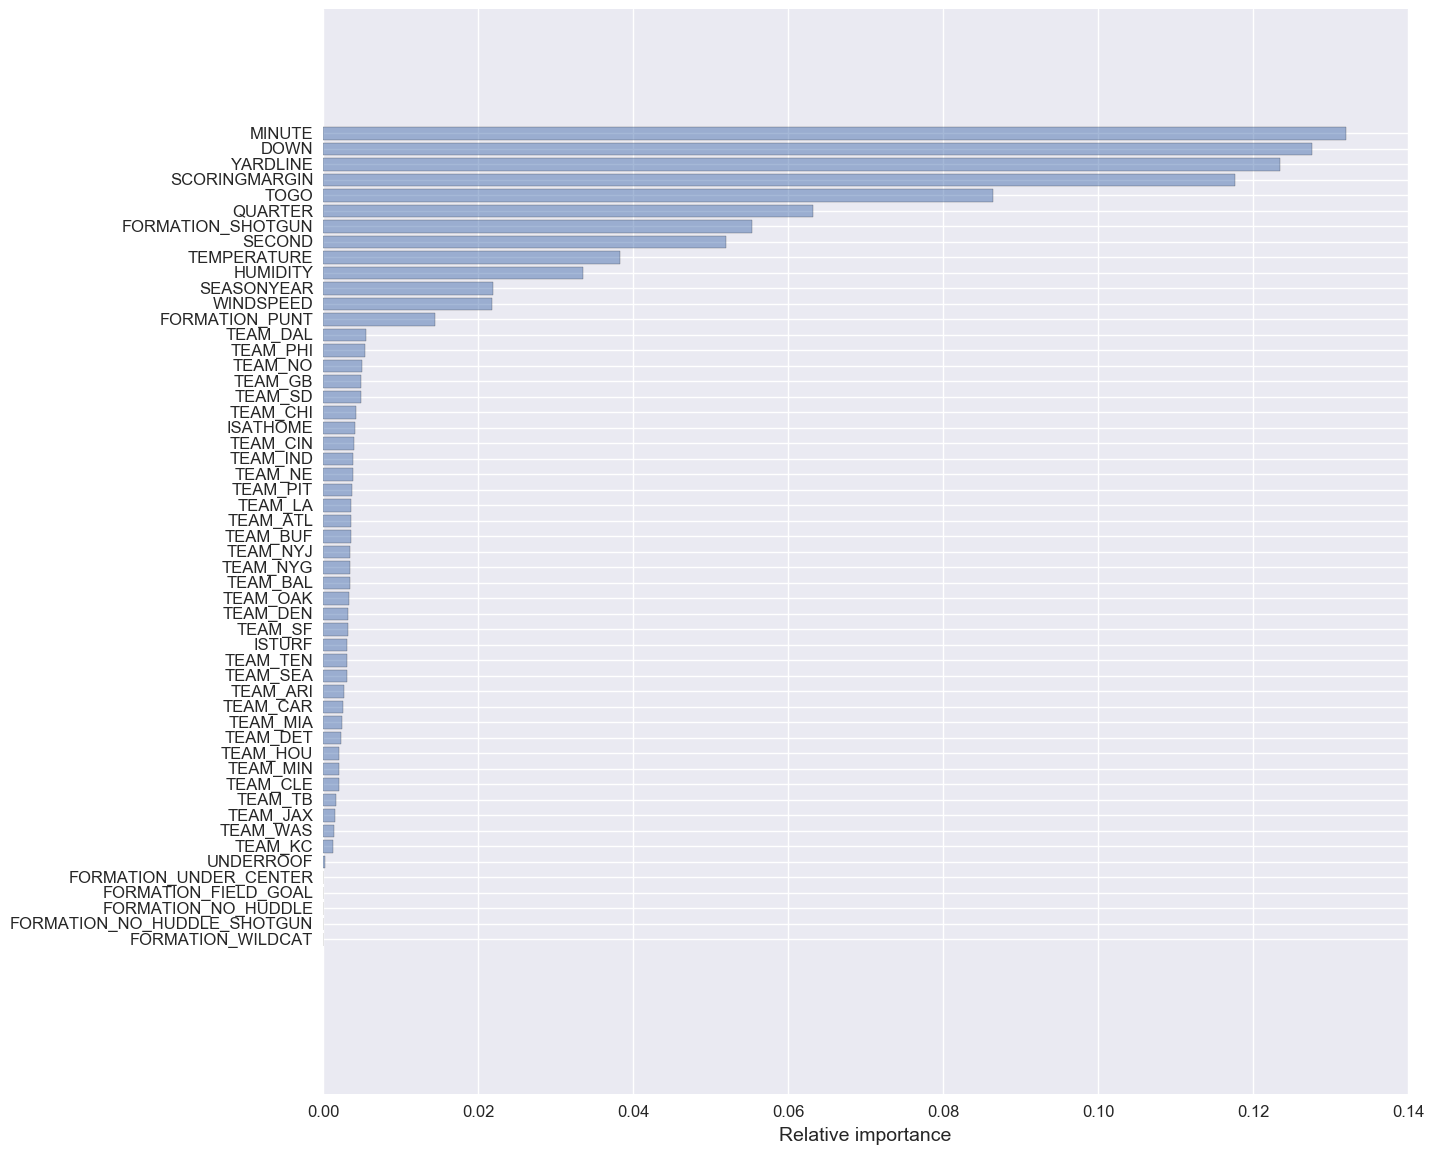

In [27]:
# sort importances
indices = np.argsort(gd_best.feature_importances_)

# plot as bar chart
figure = plt.figure(figsize=(14,14))
plt.barh(np.arange(len(col_names)), gd_best.feature_importances_[indices],
         align='center', alpha=.5)
plt.yticks(np.arange(len(col_names)), np.array(col_names)[indices], fontsize=12)
plt.xticks(fontsize=12)
_ = plt.xlabel('Relative importance', fontsize=14)



Feature ranking:
1. feature MINUTE (0.132019)
2. feature DOWN (0.127642)
3. feature YARDLINE (0.123445)
4. feature SCORINGMARGIN (0.117722)
5. feature TOGO (0.086439)
6. feature QUARTER (0.063260)
7. feature FORMATION_SHOTGUN (0.055368)
8. feature SECOND (0.052050)
9. feature TEMPERATURE (0.038330)
10. feature HUMIDITY (0.033503)
11. feature SEASONYEAR (0.021867)
12. feature WINDSPEED (0.021756)
13. feature FORMATION_PUNT (0.014396)
14. feature TEAM_DAL (0.005575)
15. feature TEAM_PHI (0.005440)
16. feature TEAM_NO (0.004972)
17. feature TEAM_GB (0.004887)
18. feature TEAM_SD (0.004833)
19. feature TEAM_CHI (0.004259)
20. feature ISATHOME (0.004093)
21. feature TEAM_CIN (0.003986)
22. feature TEAM_IND (0.003880)
23. feature TEAM_NE (0.003816)
24. feature TEAM_PIT (0.003681)
25. feature TEAM_LA (0.003653)
26. feature TEAM_ATL (0.003620)
27. feature TEAM_BUF (0.003570)
28. feature TEAM_NYJ (0.003523)
29. feature TEAM_NYG (0.003517)
30. feature TEAM_BAL (0.003466)
31. feature TEAM_OAK (0.

(-1, 53)

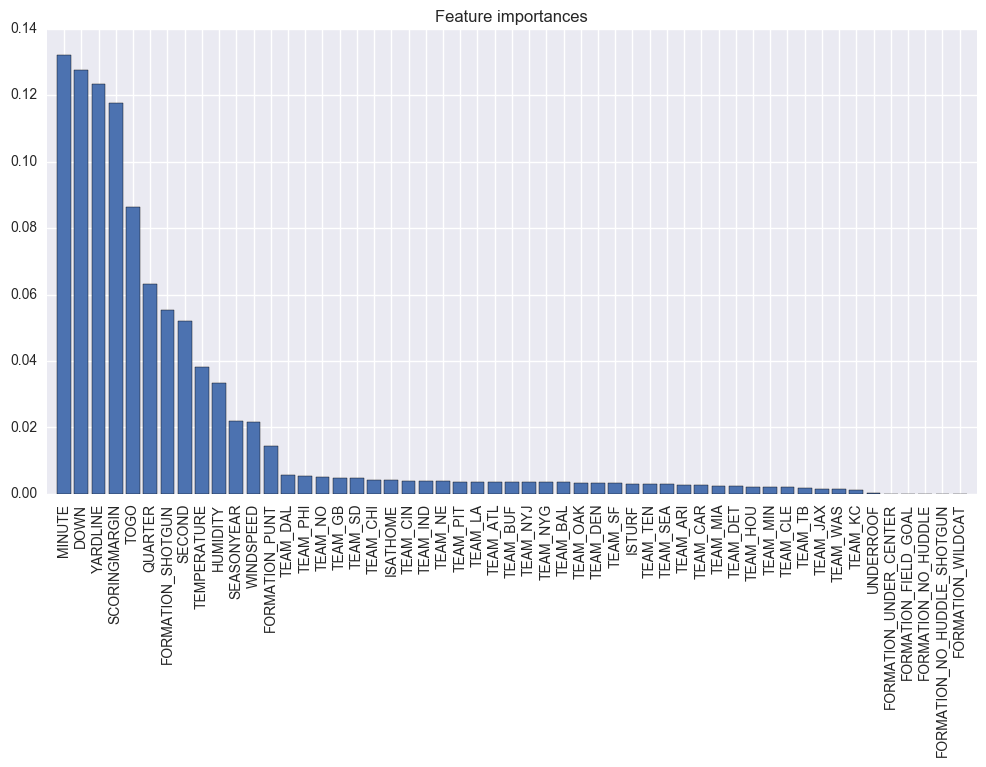

In [32]:
importances = gd_best.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feature_names = []
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col_names[indices[f]], importances[indices[f]]))
    feature_names.append(col_names[indices[f]])
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title("RelatFeature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])

In [29]:
for tree in gd_best.estimators_:
    print 

array([[ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=1.0,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x116f32960>,
           splitter='best'),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=1.0,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x116f32960>,
           splitter='best'),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=1.0,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomSt